<!-- <img  src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 15%; margin-right: 5%; margin-left: 17%; margin-top: 1.0em; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 0%; margin-left: 0%; margin-bottom: 2.0em;">
<img src="https://cms-docdb.cern.ch/cgi-bin/PublicDocDB/RetrieveFile?docid=3045&filename=CMSlogo_color_label_1024_May2014.png&version=3" alt="CMS" style="float: left; width: 12%; margin-left: 5%; margin-right: 5%; margin-bottom: 2.0em;"> -->
<p style="clear: both;">
<div style="text-align:center"><h1>CMS H&#8594;µµ analysis  
     <br> with Coffea package from Fermilab</h1></div>
<div style="text-align:center"><i>Author: Dmitry Kondratyev, based on example code by Lindsey Gray</i></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

# Search for Higgs boson decaying into two muons

This code uses awkward array toolset, and utilizing Coffea [histograms](https://coffeateam.github.io/coffea/modules/coffea.hist.html).
This also shows the analysis object syntax implemented by Coffea [JaggedCandidateArray](https://coffeateam.github.io/coffea/api/coffea.analysis_objects.JaggedCandidateMethods.html), and the usage of custom [accumulators](https://coffeateam.github.io/coffea/api/coffea.processor.AccumulatorABC.html) other than histograms.  Further, it introduces the [processor](https://coffeateam.github.io/coffea/api/coffea.processor.ProcessorABC.html) concept and the interface to apache spark.


Instructions to run at SWAN:
===

#### Load SWAN environment: LCG96 Python3 stack and Cloud Containers cluster

Then run next two cells


In [ ]:
# Run this cell if you do not have coffea installed (e.g. on SWAN with LCG 96Python3 stack)
!pip install --user --upgrade coffea

# spark.jars.packages doesnt work with Spark 2.4 with kubernetes
!wget -N https://repo1.maven.org/maven2/edu/vanderbilt/accre/laurelin/0.5.1/laurelin-0.5.1.jar && \
wget -N https://repo1.maven.org/maven2/org/apache/logging/log4j/log4j-api/2.11.2/log4j-api-2.11.2.jar && \
wget -N https://repo1.maven.org/maven2/org/apache/logging/log4j/log4j-core/2.11.2/log4j-core-2.11.2.jar && \
wget -N https://repo1.maven.org/maven2/org/lz4/lz4-java/1.5.1/lz4-java-1.5.1.jar && \
wget -N https://repo1.maven.org/maven2/org/tukaani/xz/1.2/xz-1.2.jar
                    
!mkdir output

In [ ]:
# Run this cell before establishing spark connection

import os
os.environ['PYTHONPATH'] = os.environ['PYTHONPATH'] + ':' + '/usr/local/lib/python3.6/site-packages'

Instructions to run at Purdue Jupyter hub:
===

- Login to interactive node on a cluster (e.g. `hammer.rcac.purdue.edu`)
- Activate local conda environment (create a new directory for the environment, if needed):
```
   module load anaconda/5.3.1-py37 
   source activate /home/dkondra/conda_tests/
```
- Once the environment is activated, `conda install` will automatically install packages to that environment
- Install missing packages like this: `conda install [-c conda-forge] <package name>`
- `coffea` can be installed like this (it will use conda's `pip`): 
```
    pip install --upgrade coffea
```
- In order for conda to work with notebooks, install `nb_conda`: 
```
    conda install nb_conda
```
- After that, in Jupyter notebook there will be an option in **Kernel -> Change Kernel** to run the notebook using desired conda environment
- Set up VOMS proxy:
```
    . setup_proxy.sh
```

In [1]:
%env X509_USER_PROXY=/home/dkondra/x509up_u616617

env: X509_USER_PROXY=/home/dkondra/x509up_u616617


In [2]:
import time
import coffea
print("Coffea version: ", coffea.__version__)
import socket
at_purdue = ('hammer' in socket.gethostname())

from coffea import util
import coffea.processor as processor


Coffea version:  0.6.30


In [3]:
from python.samples_info import SamplesInfo
samples = [
#   'data_G',

#      'dy_0j',
#     'dy_1j', 
#     'dy_2j',
#    'dy_m105_160_amc',
#     'dy_m105_160_vbf_amc',
#     'ewk_lljj_mll50_mjj120', #done
#    'ewk_lljj_mll105_160', #done
    "ewk_lljj_mll105_160_ptj0", #done
#    'ttjets_dl', 
#    'ggh_amcPS', # done
#     'vbf_amcPS', # done
#     'ggh_powheg', 'ggh_powhegPS',
#     'vbf_powheg', 'vbf_powhegPS', 'vbf_powheg_herwig',

    
#   'ttjets_sl', # fails - too big? #done
#     'ttz', # done
#     'ttw', # done
#    'st_tw_top','st_tw_antitop', # done
#    'ww_2l2nu', # done
#     'wz_2l2q', # done
#     'wz_3lnu', # done
#     'wz_1l1nu2q','zz',
#    'www','wwz', # done
#     'wzz','zzz', # done
#       'data_B','data_C','data_D','data_E','data_F','data_G','data_H',

]

purdue = 'root://xrootd.rcac.purdue.edu/'
legrano = 'root://t2-xrdcms.lnl.infn.it:7070//'

# samp_info = SamplesInfo(year="2016", out_path='/depot/cms/hmm/coffea/test_large/', server=purdue, datasets_from='purdue', debug=False)
samp_info = SamplesInfo(year="2016", out_path='/depot/cms/hmm/coffea/test_large/', server=legrano, datasets_from='pisa', debug=False)

# samp_info = SamplesInfo(year="2016", out_path='/depot/cms/hmm/coffea/test_long/', server=purdue, debug=False)
samp_info.load(samples)
samp_info.compute_lumi_weights()

Loading ewk_lljj_mll105_160_ptj0
Loading took 128.77 s


Iterative executor
===


In [ ]:
from coffea.processor.executor import iterative_executor
from python.dimuon_processor import DimuonProcessor

# include this to make it work at Purdue:
from ipywidgets import IntProgress, HBox, HTML
# however, still doesn't show a nice progress bar widget

tstart = time.time() 
output = processor.run_uproot_job(samp_info.full_fileset, 'Events', DimuonProcessor(
                                                                     samp_info=samp_info,\
                                                                     do_roccor=False,\
                                                                     do_fsr=True,\
                                                                     evaluate_dnn=False,\
                                                                     do_timer=True),\
                                        iterative_executor, executor_args={'nano': True})
elapsed = time.time() - tstart

print(f"Processed {output['cutflow']['all events']} events")
print(f"Total time: {elapsed} s")
print(f"Rate: {output['cutflow']['all events']/elapsed} events/s")

Dask executor
===


In [4]:
import pytest
from coffea.processor.executor import dask_executor
import dask
from python.dimuon_processor import DimuonProcessor


if at_purdue:
    n_workers = 18
else:
    n_workers = 4

distributed = pytest.importorskip("distributed", minversion="1.28.1")
distributed.config['distributed']['worker']['memory']['terminate'] = False
client = distributed.Client(processes=True, dashboard_address=None, n_workers=n_workers, threads_per_worker=1) 

tstart = time.time()
 
for label, fileset_ in samp_info.filesets.items():
    print(f"Processing {label}...")
    output = processor.run_uproot_job(fileset_, 'Events',\
                                  DimuonProcessor(samp_info=samp_info,\
                                                  do_fsr=True,\
                                                  do_roccor=True,\
                                                  evaluate_dnn=False,),\
                                  dask_executor,\
                                  executor_args={'nano': True, 'client': client})

    prefix = ""
    out_path = f"{samp_info.out_path}/{prefix}{label}.coffea"
    util.save(output, out_path)
    print(f"Saved output to {out_path}")   
    
elapsed = time.time() - tstart

print(f"Total time: {elapsed} s")


Processing ewk_lljj_mll105_160_ptj0...
Saved output to /depot/cms/hmm/coffea/test_large//ewk_lljj_mll105_160_ptj0.coffea
Total time: 1396.4989216327667 s


Plotting
===

Make plots and put them into a grid

Plot Data/MC comparison
---

Loading output from /depot/cms/hmm/coffea/test_large//data_B.coffea
Loading output from /depot/cms/hmm/coffea/test_large//data_C.coffea
Loading output from /depot/cms/hmm/coffea/test_large//data_D.coffea
Loading output from /depot/cms/hmm/coffea/test_large//data_E.coffea
Loading output from /depot/cms/hmm/coffea/test_large//data_F.coffea
Loading output from /depot/cms/hmm/coffea/test_large//data_G.coffea
Loading output from /depot/cms/hmm/coffea/test_large//data_H.coffea
Loading output from /depot/cms/hmm/coffea/test_large//dy_0j.coffea
Loading output from /depot/cms/hmm/coffea/test_large//dy_1j.coffea
Loading output from /depot/cms/hmm/coffea/test_large//dy_2j.coffea
Loading output from /depot/cms/hmm/coffea/test_large//dy_m105_160_amc.coffea
Loading output from /depot/cms/hmm/coffea/test_large//dy_m105_160_vbf_amc.coffea
Loading output from /depot/cms/hmm/coffea/test_large//ewk_lljj_mll50_mjj120.coffea
Loading output from /depot/cms/hmm/coffea/test_large//ewk_lljj_mll105_160_ptj0.cof

/home/dkondra/conda_tests/lib/python3.7/site-packages/coffea/hist/hist_tools.py:346: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7fb7be5ad208>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/home/dkondra/conda_tests/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/dkondra/conda_tests/lib/python3.7/site-packages/mplhep/plot.py:194: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  label=_labels[0], **kwargs)
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
/home/dkondra/conda_tests/lib/python3.7/site-packages/coffea/hist/plot.py:351: RuntimeWarning: invalid

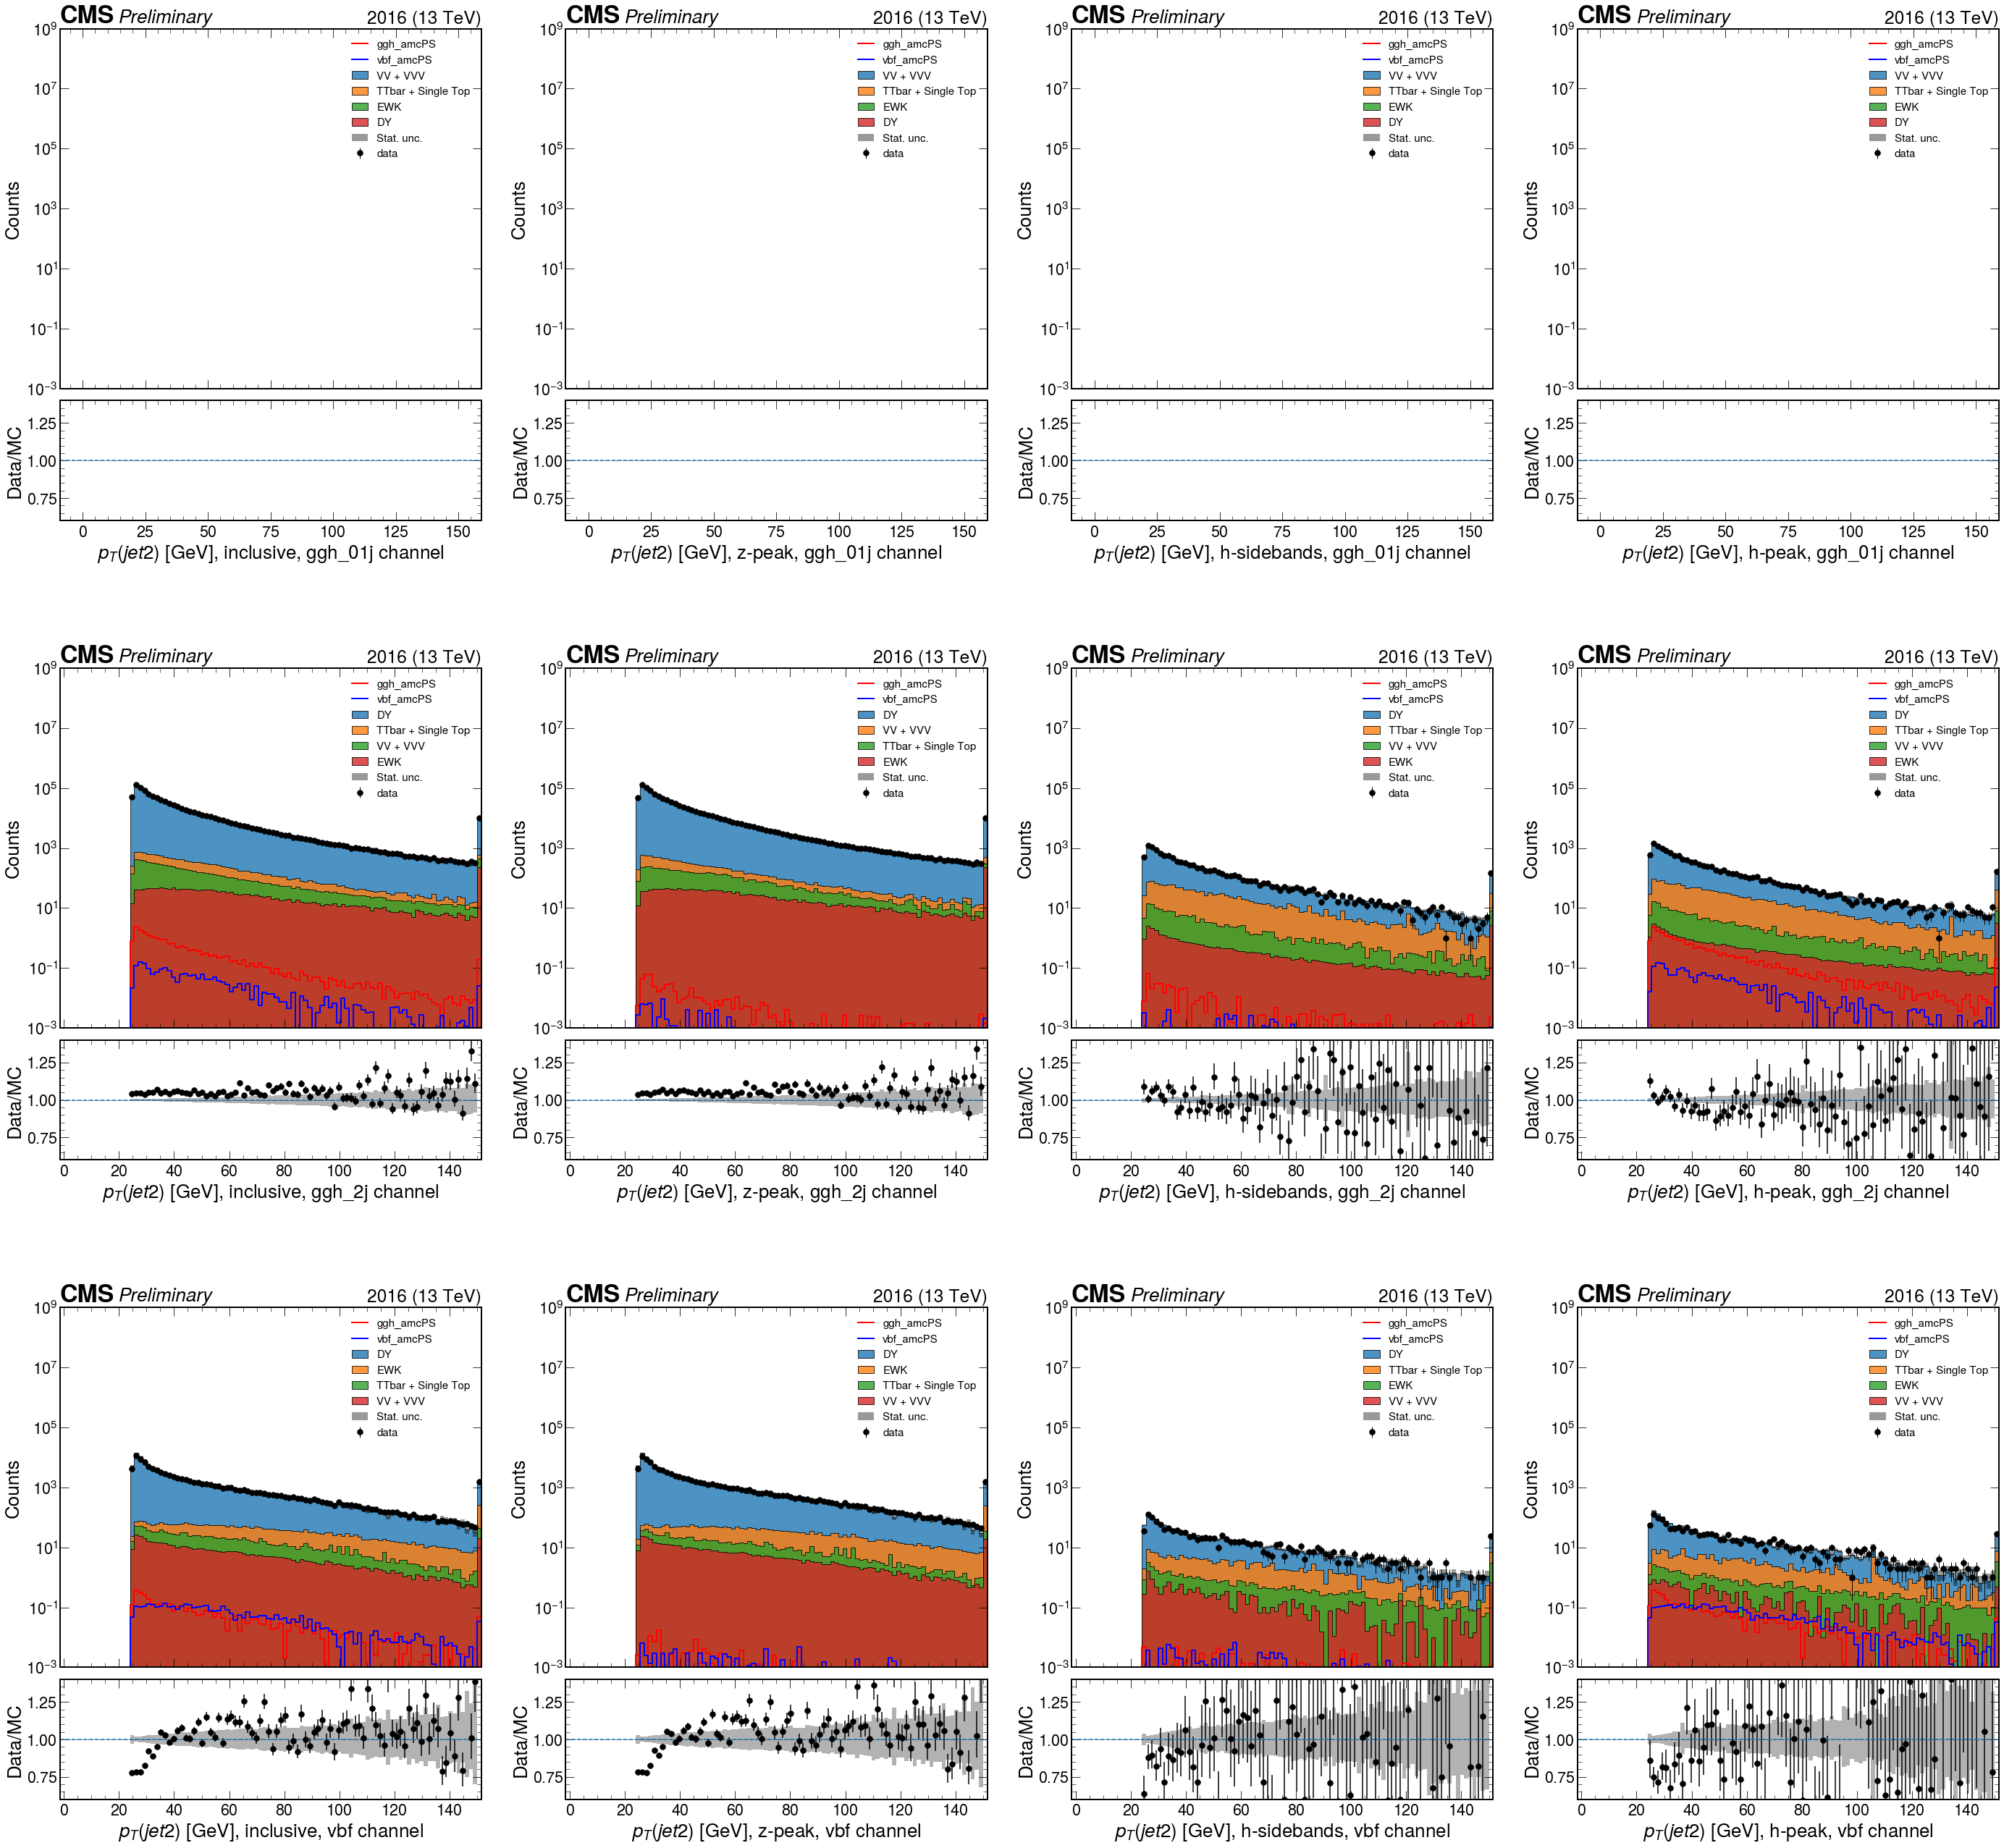

In [5]:
%matplotlib inline
from python.plotting import Plotter
from python.dimuon_processor import DimuonProcessor
    
vars_to_plot = []

# vars_to_plot += ['dimuon_mass', 'dimuon_pt']
# vars_to_plot += ['dimuon_mass_res', 'dimuon_mass_res_rel']
# vars_to_plot += ['dimuon_eta', 'dimuon_phi']
# vars_to_plot += ['dimuon_dEta', 'dimuon_dPhi', 'dimuon_dR']
# vars_to_plot += ['mu1_pt', 'mu1_pt_over_mass', 'mu1_eta', 'mu1_phi']
# vars_to_plot += ['mu2_pt', 'mu2_pt_over_mass', 'mu2_eta', 'mu2_phi']
# vars_to_plot += ['jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_qgl']
vars_to_plot += ['jet2_pt']#, 'jet2_eta', 'jet2_phi', 'jet2_qgl']
# vars_to_plot += ['deta_mumuj1', 'dphi_mumuj1']
# vars_to_plot += ['deta_mumuj2', 'dphi_mumuj2']
# vars_to_plot += ['jj_mass']
# vars_to_plot += ['jj_pt', 'jj_eta', 'jj_phi']
# vars_to_plot += ['jj_dEta', 'jj_dPhi']
# vars_to_plot += ['njets', 'npv', 'met']
# vars_to_plot += ['dnn_score']

all_plots_2016_pars = {
    'processor': DimuonProcessor(),
    'path': '/depot/cms/hmm/coffea/test_large/',
    'prefix': '',
    'samples': [
        'data_B','data_C','data_D','data_E','data_F','data_G','data_H',
        'dy_0j', 'dy_1j', 'dy_2j',
        'dy_m105_160_amc',
        'dy_m105_160_vbf_amc',
        'ewk_lljj_mll50_mjj120', 
        'ewk_lljj_mll105_160_ptj0',
        'ttjets_dl', 
        'ggh_amcPS', 'vbf_amcPS',
        'ttjets_sl', 'ttz', 'ttw',
        'st_tw_top','st_tw_antitop',
        'ww_2l2nu','wz_2l2q','wz_3lnu','wz_1l1nu2q','zz',
        'www','wwz','wzz','zzz',
        ],
    'vars': vars_to_plot,
    'year': '2016',
    'regions' : ["z-peak", "h-sidebands", "h-peak"],
    'channels': ["ggh_01j", "ggh_2j", "vbf"], 
#     'regions' : ["h-peak"],
#     'channels': ["vbf"], 
}

all_plots = Plotter(**all_plots_2016_pars)
all_plots.make_datamc_comparison(do_inclusive=True, do_exclusive=True, normalize=False, logy=True)


Loading output from /depot/cms/hmm/coffea/test_large//data_B.coffea
Loading output from /depot/cms/hmm/coffea/test_large//data_C.coffea
Loading output from /depot/cms/hmm/coffea/test_large//data_D.coffea
Loading output from /depot/cms/hmm/coffea/test_large//data_E.coffea
Loading output from /depot/cms/hmm/coffea/test_large//data_F.coffea
Loading output from /depot/cms/hmm/coffea/test_large//data_G.coffea
Loading output from /depot/cms/hmm/coffea/test_large//data_H.coffea
Loading output from /depot/cms/hmm/coffea/test_large//dy_0j.coffea
Loading output from /depot/cms/hmm/coffea/test_large//dy_1j.coffea
Loading output from /depot/cms/hmm/coffea/test_large//dy_2j.coffea
Loading output from /depot/cms/hmm/coffea/test_large//dy_m105_160_amc.coffea
Loading output from /depot/cms/hmm/coffea/test_large//dy_m105_160_vbf_amc.coffea
Loading output from /depot/cms/hmm/coffea/test_large//ewk_lljj_mll50_mjj120.coffea
Loading output from /depot/cms/hmm/coffea/test_large//ewk_lljj_mll105_160.coffea
L

/home/dkondra/conda_tests/lib/python3.7/site-packages/coffea/hist/hist_tools.py:346: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f090b150cf8>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


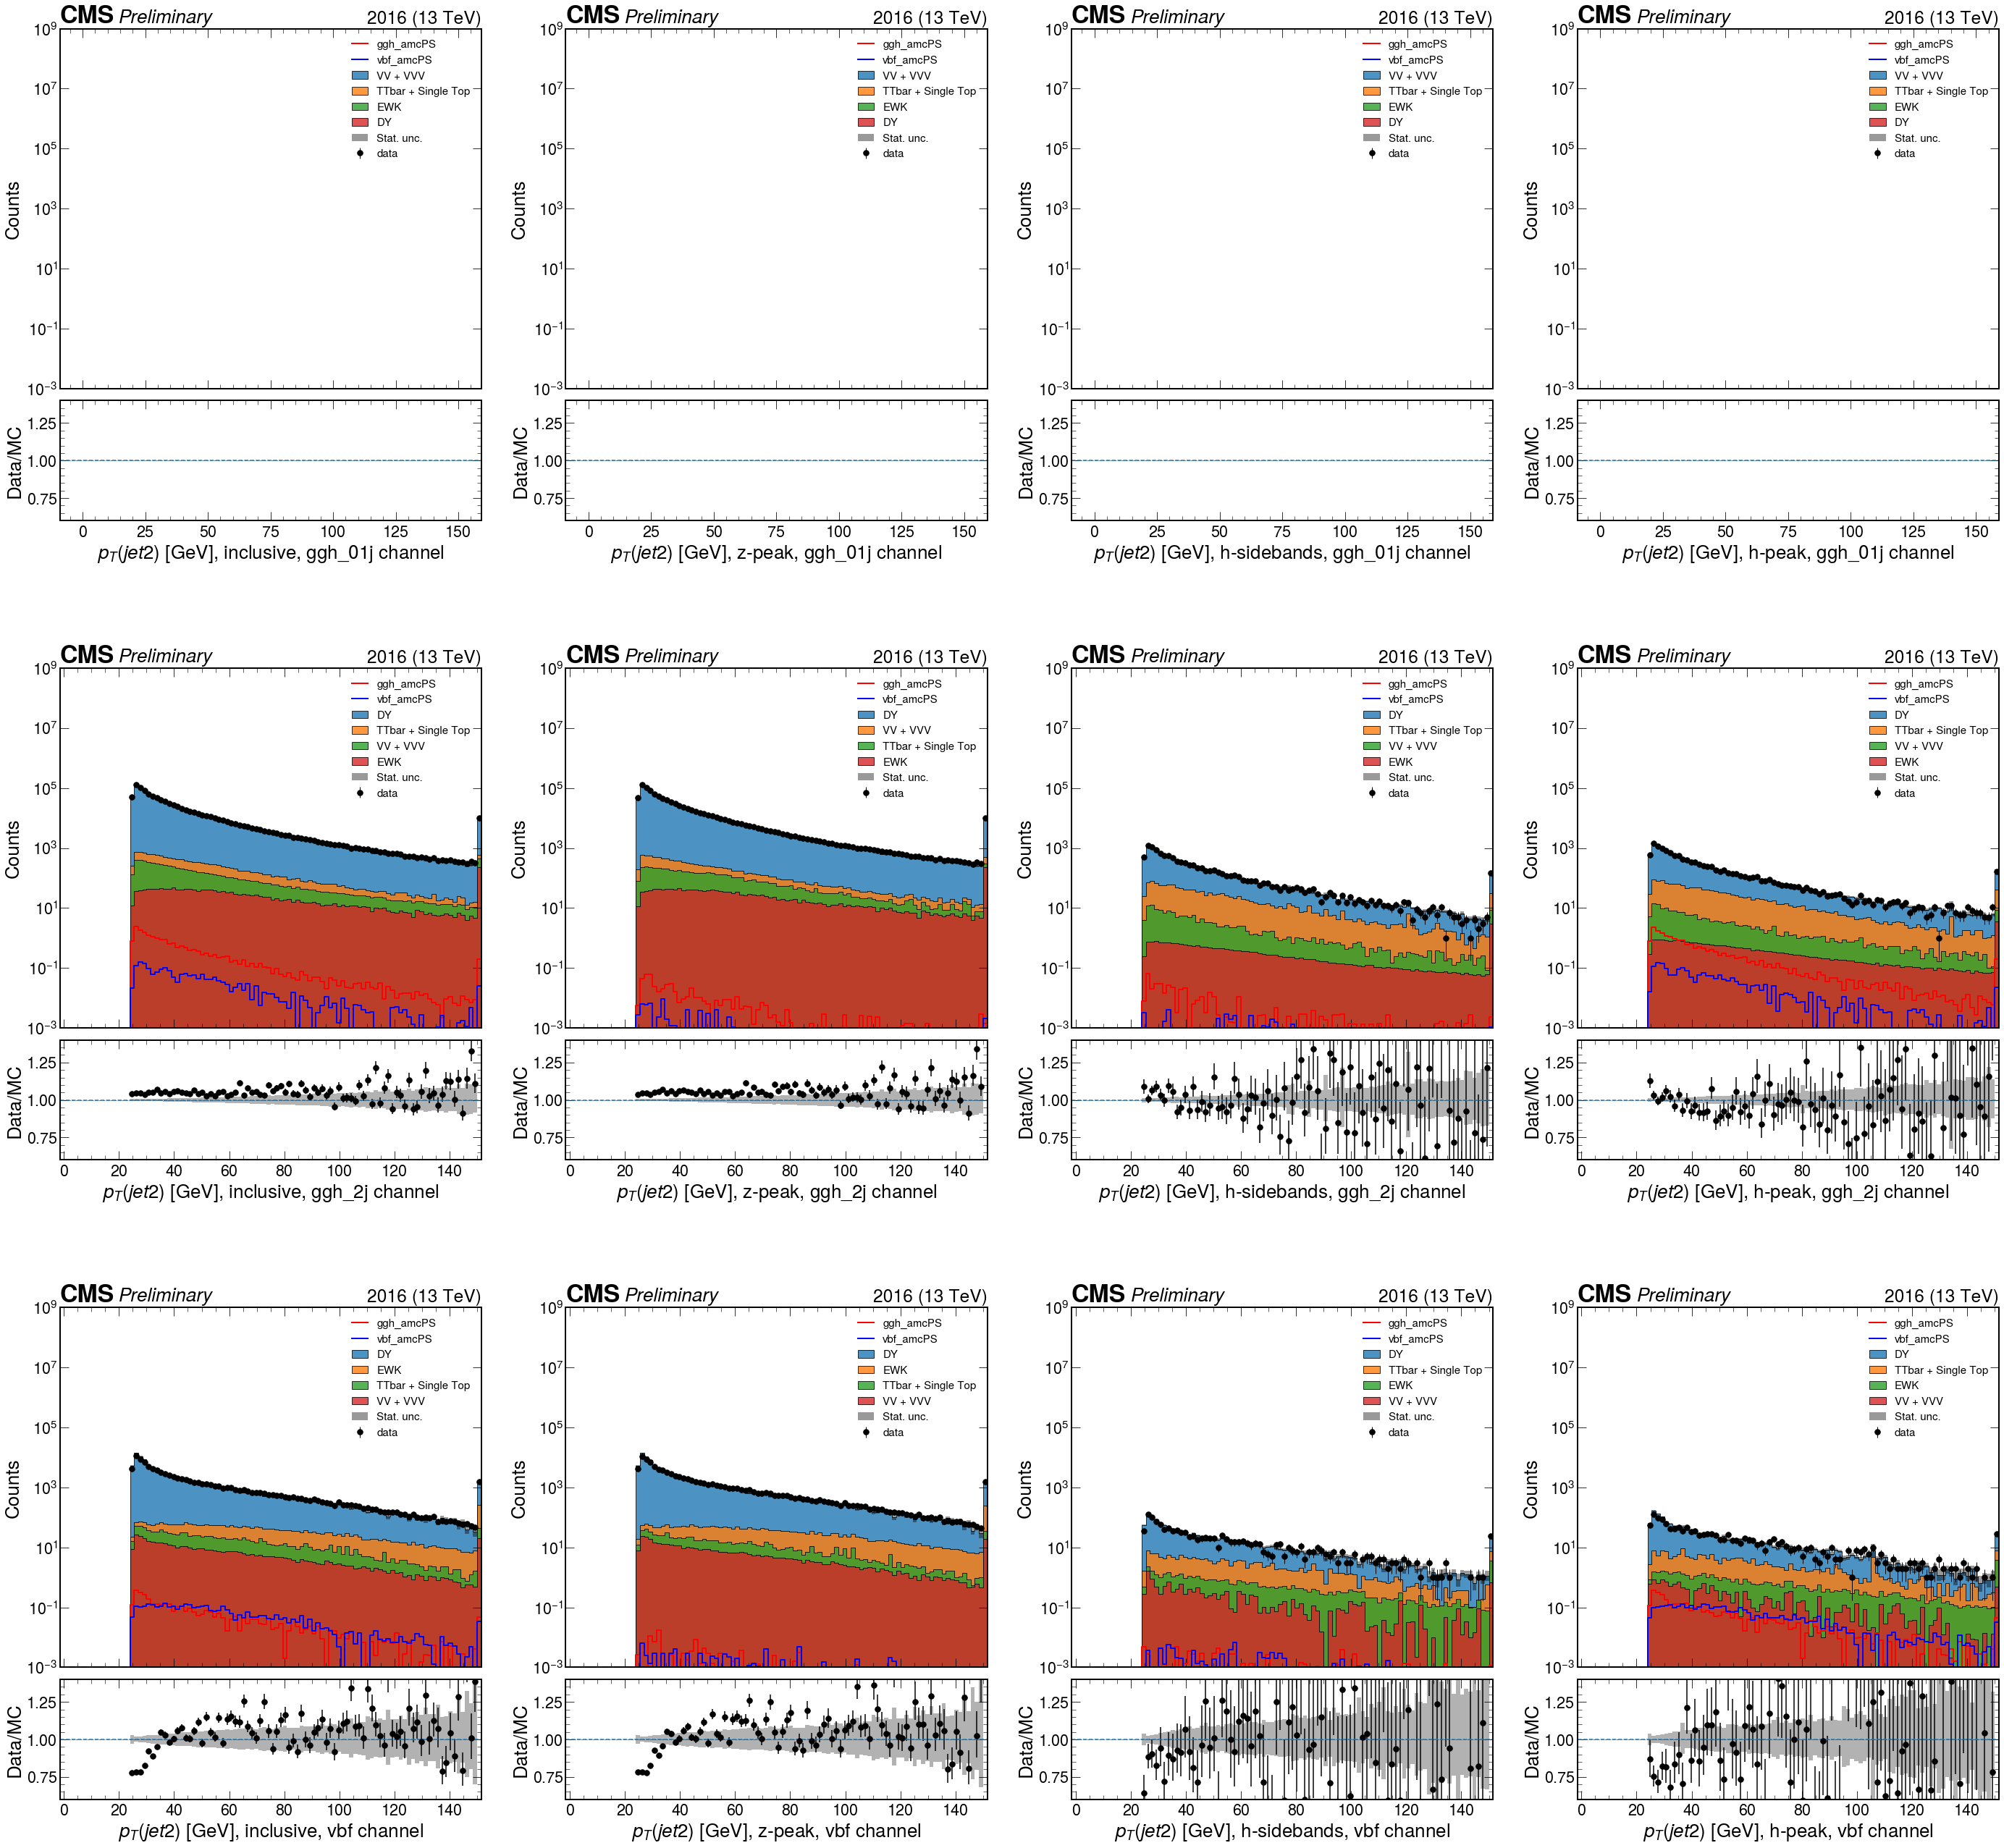

In [2]:
%matplotlib inline
from python.plotting import Plotter
from python.dimuon_processor import DimuonProcessor
    
vars_to_plot = []

# vars_to_plot += ['dimuon_mass', 'dimuon_pt']
# vars_to_plot += ['dimuon_mass_res', 'dimuon_mass_res_rel']
# vars_to_plot += ['dimuon_eta', 'dimuon_phi']
# vars_to_plot += ['dimuon_dEta', 'dimuon_dPhi', 'dimuon_dR']
# vars_to_plot += ['mu1_pt', 'mu1_pt_over_mass', 'mu1_eta', 'mu1_phi']
# vars_to_plot += ['mu2_pt', 'mu2_pt_over_mass', 'mu2_eta', 'mu2_phi']
# vars_to_plot += ['jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_qgl']
vars_to_plot += ['jet2_pt']#, 'jet2_eta', 'jet2_phi', 'jet2_qgl']
# vars_to_plot += ['deta_mumuj1', 'dphi_mumuj1']
# vars_to_plot += ['deta_mumuj2', 'dphi_mumuj2']
# vars_to_plot += ['jj_mass']
# vars_to_plot += ['jj_pt', 'jj_eta', 'jj_phi']
# vars_to_plot += ['jj_dEta', 'jj_dPhi']
# vars_to_plot += ['njets', 'npv', 'met']
# vars_to_plot += ['dnn_score']

all_plots_2016_pars = {
    'processor': DimuonProcessor(),
    'path': '/depot/cms/hmm/coffea/test_large/',
    'prefix': '',
    'samples': [
        'data_B','data_C','data_D','data_E','data_F','data_G','data_H',
        'dy_0j', 'dy_1j', 'dy_2j',
        'dy_m105_160_amc',
        'dy_m105_160_vbf_amc',
        'ewk_lljj_mll50_mjj120', 
        'ewk_lljj_mll105_160',
        'ttjets_dl', 
        'ggh_amcPS', 'vbf_amcPS',
        'ttjets_sl', 'ttz', 'ttw',
        'st_tw_top','st_tw_antitop',
        'ww_2l2nu','wz_2l2q','wz_3lnu','wz_1l1nu2q','zz',
        'www','wwz','wzz','zzz',
        ],
    'vars': vars_to_plot,
    'year': '2016',
    'regions' : ["z-peak", "h-sidebands", "h-peak"],
    'channels': ["ggh_01j", "ggh_2j", "vbf"], 
#     'regions' : ["h-peak"],
#     'channels': ["vbf"], 
}

all_plots = Plotter(**all_plots_2016_pars)
all_plots.make_datamc_comparison(do_inclusive=True, do_exclusive=True, normalize=False, logy=True)


Plot jet distributions for new EWK samples
---

In [ ]:
%matplotlib inline
from python.plotting import Plotter
from python.dimuon_processor import DimuonProcessor

ewz_study_pars = {
    'processor': DimuonProcessor(),
    'path': '/depot/cms/hmm/coffea/pisa_test/',
    'prefix': '',
#     'samples': ['ewk_lljj_mll105_160_ptj0b'],
    'samples': [
        'data_B','data_C','data_D','data_E','data_F','data_G','data_H',
        'dy_0j', 'dy_1j', 'dy_2j',
        'dy_m105_160_amc',
        'dy_m105_160_vbf_amc',
        'ewk_lljj_mll50_mjj120', 'ewk_lljj_mll105_160',
        'ttjets_dl', 
        'ggh_amcPS', 'vbf_amcPS',
        'ttjets_sl', 'ttz', 'ttw',
        'st_tw_top','st_tw_antitop',
        'ww_2l2nu','wz_2l2q','wz_3lnu','wz_1l1nu2q','zz',
        'www','wwz','wzz','zzz',
    ],
#     'vars': ['jet1_pt', 'jet1_eta', 'jet2_pt', 'jet2_eta'],
    'vars': ['htsoft2', 'htsoft5', 'nsoftjets2', 'nsoftjets5'],
#     'vars': ['dimuon_mass'],
    'year': '2016',
    'regions' : ["z-peak", "h-sidebands", "h-peak"],
    'channels': ["ggh_01j", "ggh_2j", "vbf"], 
}

ewz_study_plots = Plotter(**ewz_study_pars)
# ewz_study_plots.make_shape_comparison(do_inclusive=True, do_exclusive=False)
ewz_study_plots.make_datamc_comparison(do_inclusive=True, do_exclusive=False, logy=True)


Roccor test
===

In [ ]:
import time
import coffea
print("Coffea version: ", coffea.__version__)
import socket
at_purdue = ('hammer' in socket.gethostname())

from coffea import util
import coffea.processor as processor

import pytest
from coffea.processor.executor import dask_executor
import dask
from python.dimuon_processor import DimuonProcessor

if at_purdue:
    n_workers = 18
else:
    n_workers = 4

distributed = pytest.importorskip("distributed", minversion="1.28.1")
distributed.config['distributed']['worker']['memory']['terminate'] = False
client = distributed.Client(processes=True, dashboard_address=None, n_workers=n_workers, threads_per_worker=1) 

from python.samples_info import SamplesInfo

purdue = 'root://xrootd.rcac.purdue.edu/'
samp_info_fsr_test = SamplesInfo(year="2016", out_path='/depot/cms/hmm/coffea/roccor_test/', server=purdue, datasets_from='purdue', debug=True)
samp_info_fsr_test.load(['dy_m105_160_amc'])
samp_info_fsr_test.compute_lumi_weights()

for do_roccor in [True, False]:
    for label, fileset_ in samp_info_fsr_test.filesets.items():
        print(f"Processing {label}...")
        output = processor.run_uproot_job(fileset_, 'Events',\
                                      DimuonProcessor(samp_info=samp_info_fsr_test,\
                                                      do_fsr=True,\
                                                      do_roccor=do_roccor,\
                                                      evaluate_dnn=False,),\
                                      dask_executor,\
                                      executor_args={'nano': True, 'client': client})

        prefix = "roccor_" if do_roccor else "noroccor_"
        out_path = f"{samp_info_fsr_test.out_path}/{prefix}{label}.coffea"
        util.save(output, out_path)
        print(f"Saved output to {out_path}") 


%matplotlib inline
from python.plotting import Plotter
from python.dimuon_processor import DimuonProcessor

fsr_study_pars = {
    'processor': DimuonProcessor(),
    'path': '/depot/cms/hmm/coffea/roccor_test/',
    'prefix': '',
    'files': ['roccor_dy_m105_160_amc', 'noroccor_dy_m105_160_amc'],
    'samples': ['dy_m105_160_amc'],
    'vars': ['dimuon_mass'],
    'year': '2016',
    'regions' : ["h-sidebands", "h-peak", "z-peak"],
    'channels': ["vbf"], 
    'merge_files': False,
}

fsr_study_plots = Plotter(**fsr_study_pars)
fsr_study_plots.make_shape_comparison(do_inclusive=True, do_exclusive=False)
